# [1] TSNE Plots for Amazon Fine Food Reviews






## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

##   Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [10]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [12]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
final.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [13]:
type(final['Score'])
positive_reviews_sample=final[final['Score']=='positive'].sample(n=1000)
negative_reviews_sample=final[final['Score']=='negative'].sample(n=1000)
final_reviews=pd.concat([positive_reviews_sample,negative_reviews_sample])

#  Bag of Words (BoW)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 9020)
the number of unique words  9020
(4000, 2)
(4000, 3)


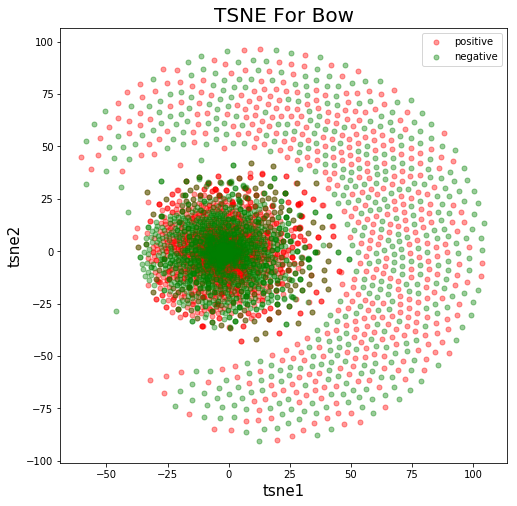

In [17]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_reviews['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
finall=final_counts.toarray()

ss= StandardScaler(with_mean=True)
standardized_bow=ss.fit_transform(finall)



#Tsne visualization for bow
model = TSNE(n_components=2, random_state=0,perplexity=30)
tsne_data = model.fit_transform(standardized_bow)
print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data,columns=['tsne1','tsne2'])
finalDf = pd.concat([tsne_df,final_reviews[['Score']].reset_index(drop=True)], axis = 1)
print(finalDf.shape)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tsne1', fontsize = 15)
ax.set_ylabel('tsne2', fontsize = 15)
ax.set_title('TSNE For Bow', fontsize = 20)

#In this example 0:Negative and 1:Positive and we map respective colour
targets = ['positive', 'negative'] 
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Score'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
           , finalDf.loc[indicesToKeep, 'tsne2']
           , c = color
           , s = 25,alpha=0.4)
    ax.legend(targets)

#  TF-IDF

In [14]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_reviews['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
final_tf_idf=final_tf_idf.toarray()
type(final_tf_idf)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 67036)
the number of unique words including both unigrams and bigrams  67036


numpy.ndarray

(2000, 2)
(2000, 3)


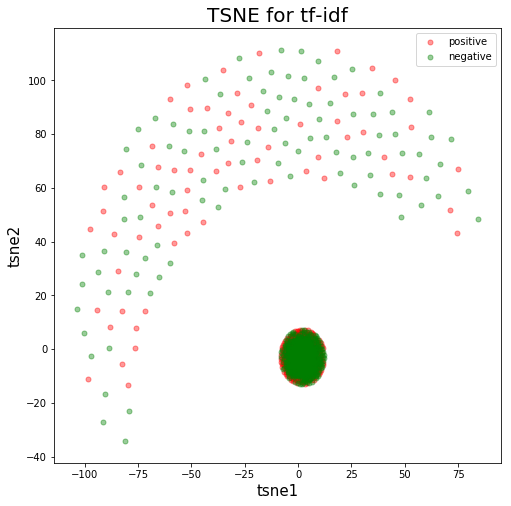

In [15]:
ss= StandardScaler(with_mean=True)
standardized_tf_idf=ss.fit_transform(final_tf_idf)


#Tsne visualization for TF_IDF
model = TSNE(n_components=2, random_state=0,perplexity=30)
tsne_data = model.fit_transform(standardized_tf_idf)
print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data,columns=['tsne1','tsne2'])
finalDf = pd.concat([tsne_df,final_reviews[['Score']].reset_index(drop=True)], axis = 1)
print(finalDf.shape)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tsne1', fontsize = 15)
ax.set_ylabel('tsne2', fontsize = 15)
ax.set_title('TSNE for tf-idf', fontsize = 20)

#In this example 0:Negative and 1:Positive and we map respective colour
targets = ['positive', 'negative'] 
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Score'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
           , finalDf.loc[indicesToKeep, 'tsne2']
           , c = color
           , s = 25,alpha=0.4)
    ax.legend(targets)

#  Word2Vec

In [16]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [17]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_reviews['CleanedText'].values:
    list_of_sent.append(sent.split())

In [18]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
final_vectors = w2v_model[w2v_model.wv.vocab]
print(final_vectors.shape)

(2065, 50)


#  Avg W2V, TFIDF-W2V

In [19]:
w2v_words = list(w2v_model.wv.vocab)
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 2000/2000 [00:05<00:00, 383.23it/s]


2000
50


(2000, 2)
(2000, 3)


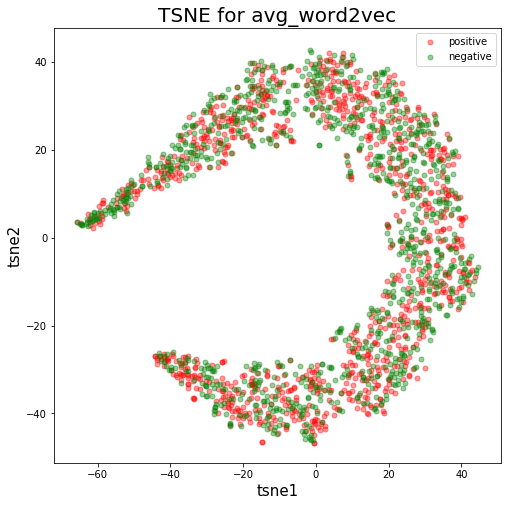

In [20]:
ss= StandardScaler(with_mean=True)
standardized_avg_word2vec=ss.fit_transform(sent_vectors)
#tsne for avg_word2vec
model = TSNE(n_components=2, random_state=0,perplexity=30)
tsne_data = model.fit_transform(standardized_avg_word2vec)
print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data,columns=['tsne1','tsne2'])
finalDf = pd.concat([tsne_df,final_reviews[['Score']].reset_index(drop=True)], axis = 1)
print(finalDf.shape)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tsne1', fontsize = 15)
ax.set_ylabel('tsne2', fontsize = 15)
ax.set_title('TSNE for avg_word2vec', fontsize = 20)

#In this example 0:Negative and 1:Positive and we map respective colour
targets = ['positive', 'negative'] 
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Score'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
           , finalDf.loc[indicesToKeep, 'tsne2']
           , c = color
           , s = 25,alpha=0.4)
    ax.legend(targets)

In [21]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [22]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 2000/2000 [00:06<00:00, 295.85it/s]


(2000, 2)
(2000, 3)


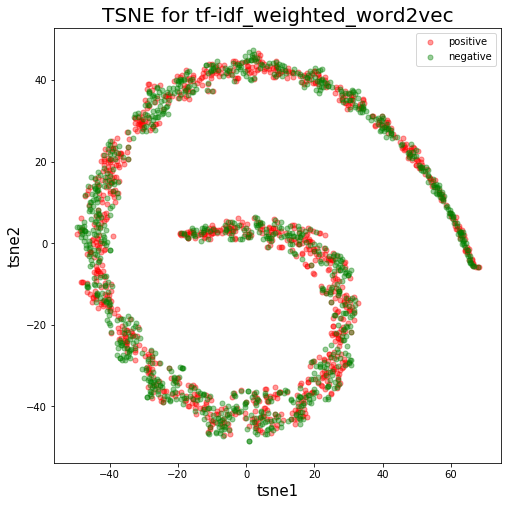

In [23]:
ss= StandardScaler(with_mean=True)
standardized_avg_word2vec=ss.fit_transform(tfidf_sent_vectors)


#tsne for TF_IDF_word2vec
model = TSNE(n_components=2, random_state=0,perplexity=30)
tsne_data = model.fit_transform(tfidf_sent_vectors)
print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data,columns=['tsne1','tsne2'])
finalDf = pd.concat([tsne_df,final_reviews[['Score']].reset_index(drop=True)], axis = 1)
print(finalDf.shape)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tsne1', fontsize = 15)
ax.set_ylabel('tsne2', fontsize = 15)
ax.set_title('TSNE for tf-idf_weighted_word2vec', fontsize = 20)

#In this example 0:Negative and 1:Positive and we map respective colour
targets = ['positive', 'negative'] 
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Score'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
           , finalDf.loc[indicesToKeep, 'tsne2']
           , c = color
           , s = 25,alpha=0.4)
    ax.legend(targets)